In [11]:
import keras
import nltk
import pandas as pd
import numpy as np
import re
import codecs
import itertools
import matplotlib
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import gensim

In [12]:
# Inspecionando os dados 
questions = pd.read_csv('https://raw.githubusercontent.com/hundredblocks/concrete_NLP_tutorial/master/socialmedia_relevant_cols.csv',encoding = "ISO-8859-1")

questions.columns=['text', 'choose_one', 'class_label']

In [13]:
#Primeiras linhas 
questions.head()

,text,choose_one,class_label
0,Just happened a terrible car crash,Relevant,1
1,Our Deeds are the Reason of this #earthquake M...,Relevant,1
2,"Heard about #earthquake is different cities, s...",Relevant,1
3,"there is a forest fire at spot pond, geese are...",Relevant,1
4,Forest fire near La Ronge Sask. Canada,Relevant,1


In [14]:
#Últimas linhas 
questions.tail()

,text,choose_one,class_label
10871,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,Relevant,1
10872,Police investigating after an e-bike collided ...,Relevant,1
10873,The Latest: More Homes Razed by Northern Calif...,Relevant,1
10874,MEG issues Hazardous Weather Outlook (HWO) htt...,Relevant,1
10875,#CityofCalgary has activated its Municipal Eme...,Relevant,1


In [15]:
questions.describe()


,class_label
count,10876.000000
mean,0.432604
std,0.498420
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,2.000000


In [16]:
# Expressões regulares para limpeza dos dados 
def standardize_text(df, text_field):    
    df[text_field] = df[text_field].str.replace(r"http\S+", "")    
    df[text_field] = df[text_field].str.replace(r"http", "")    
    df[text_field] = df[text_field].str.replace(r"@\S+", "")    
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")    
    df[text_field] = df[text_field].str.replace(r"@", "at")    
    df[text_field] = df[text_field].str.lower()    
    return df

In [18]:
#Limpeza e regravação do arquivo de saída limpo 
clean_questions = standardize_text(questions, "text") 
clean_questions.to_csv("clean_data.csv")

/tmp/ipykernel_9522/1108453554.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df[text_field] = df[text_field].str.replace(r"http\S+", "")
/tmp/ipykernel_9522/1108453554.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df[text_field] = df[text_field].str.replace(r"@\S+", "")
/tmp/ipykernel_9522/1108453554.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")


In [19]:
#Últimas linhas 
clean_questions.tail()

,text,choose_one,class_label
10871,m1 94 01 04 utc ?5km s of volcano hawaii,Relevant,1
10872,police investigating after an e bike collided ...,Relevant,1
10873,the latest more homes razed by northern calif...,Relevant,1
10874,meg issues hazardous weather outlook (hwo),Relevant,1
10875,cityofcalgary has activated its municipal eme...,Relevant,1


In [20]:
#Distribuição das classes:
clean_questions.groupby("class_label").count()

,text,choose_one
class_label,,
0,6187,6187
1,4673,4673
2,16,16


In [21]:
from nltk.tokenize import RegexpTokenizer 
# Método de quebra dos dados 
tokenizer = RegexpTokenizer(r'\w+') 


In [22]:
# Gerando listas de sentenças quebradas 
clean_questions["tokens"] = clean_questions["text"].apply(tokenizer.tokenize)

In [23]:
#Primeiras linhas 
clean_questions.head()

,text,choose_one,class_label,tokens
0,just happened a terrible car crash,Relevant,1,"[just, happened, a, terrible, car, crash]"
1,our deeds are the reason of this earthquake m...,Relevant,1,"[our, deeds, are, the, reason, of, this, earth..."
2,"heard about earthquake is different cities, s...",Relevant,1,"[heard, about, earthquake, is, different, citi..."
3,"there is a forest fire at spot pond, geese are...",Relevant,1,"[there, is, a, forest, fire, at, spot, pond, g..."
4,forest fire near la ronge sask canada,Relevant,1,"[forest, fire, near, la, ronge, sask, canada]"


In [24]:
#Últimas linhas 
clean_questions.tail()

,text,choose_one,class_label,tokens
10871,m1 94 01 04 utc ?5km s of volcano hawaii,Relevant,1,"[m1, 94, 01, 04, utc, 5km, s, of, volcano, haw..."
10872,police investigating after an e bike collided ...,Relevant,1,"[police, investigating, after, an, e, bike, co..."
10873,the latest more homes razed by northern calif...,Relevant,1,"[the, latest, more, homes, razed, by, northern..."
10874,meg issues hazardous weather outlook (hwo),Relevant,1,"[meg, issues, hazardous, weather, outlook, hwo]"
10875,cityofcalgary has activated its municipal eme...,Relevant,1,"[cityofcalgary, has, activated, its, municipal..."


In [27]:
#Inspecioanndo novamente os dados 
all_words = [word for tokens in clean_questions["tokens"] for word in tokens] 
sentence_lengths = [len(tokens) for tokens in clean_questions["tokens"]] 
VOCAB = sorted(list(set(all_words))) 
print(f"{len(all_words)} Quantidade total de palavras, com um vocabulario de {len(VOCAB)}") 
print(f"Tamanho máximo de uma sentença {max(sentence_lengths)}")

154724 Quantidade total de palavras, com um vocabulario de 18101
Tamanho máximo de uma sentença 34


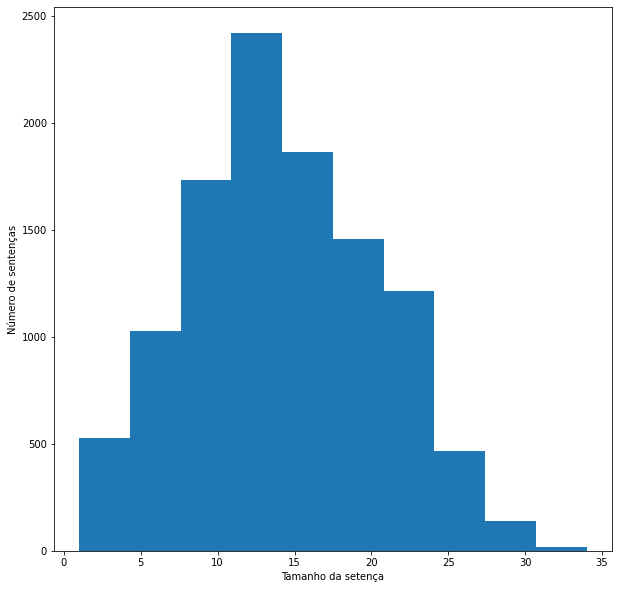

In [26]:
#Distribuilção das sentenças por quantidade de palavras 
fig = plt.figure(figsize=(10, 10)) 
plt.xlabel('Tamanho da setença') 
plt.ylabel('Número de sentenças') 
plt.hist(sentence_lengths) 
plt.show()